In [1]:
from keras.models import load_model
import pandas as pd
import cv2
from skimage.io import imread, imshow, imsave
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from utils_fcn import DataGeneratorMobileNet


Using TensorFlow backend.
/home/wvillegas/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Para medir el diametro de la mascara, sacar la distancia en el centro de masa al pixel mas lejano de la mascara.

In [2]:
fcn = load_model('/home/wvillegas/DLProjects/BudClassifier/Deteccion/models/FCNMNAdam_100ep.h5')

In [3]:
img_path = os.path.join('/home','wvillegas','dataset-mask','dataset_resize', 'images_resize')
masks_path = os.path.join('/home','wvillegas','dataset-mask','dataset_resize', 'masks_resize')

In [4]:
dataset = pd.read_csv(os.path.join('/home','wvillegas','dataset-mask', 'full_masks.csv'))


In [5]:
test_set = pd.read_csv('/home/wvillegas/DLProjects/BudClassifier/Deteccion/models/testAdam_50ep.csv', header=None)

In [6]:
img_list = list(dataset['orig'].values)
mask_list = list(dataset['mask'].values)

In [7]:
test_images = list(test_set[1].values)

In [8]:
labels = dict(zip(img_list, mask_list))

In [9]:
list_img = test_set[1][11:21].values
labels = test_set[2][11:21].values

In [10]:
inp_img = []
for img in list_img:
    temp = cv2.imread(img_path + '/' + img)
    temp = cv2.resize(temp, (0,0), fx=0.5, fy=0.5)
    temp = cv2.normalize(temp, temp, 0, 255, cv2.NORM_MINMAX)
    inp_img.append(temp)
    
ground_truth = []
for img in np.arange(0,len(list_img)):
    mask = labels[img]
    temp = cv2.imread(masks_path + '/' + mask)
    temp = cv2.resize(temp, (0,0), fx=0.5, fy=0.5)
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
    temp = temp.astype(bool).astype(int)
    ground_truth.append(temp)

In [11]:
inp_img = np.asarray(inp_img)
ground_truth = np.asarray(ground_truth)

In [12]:
pred = fcn.predict(inp_img)

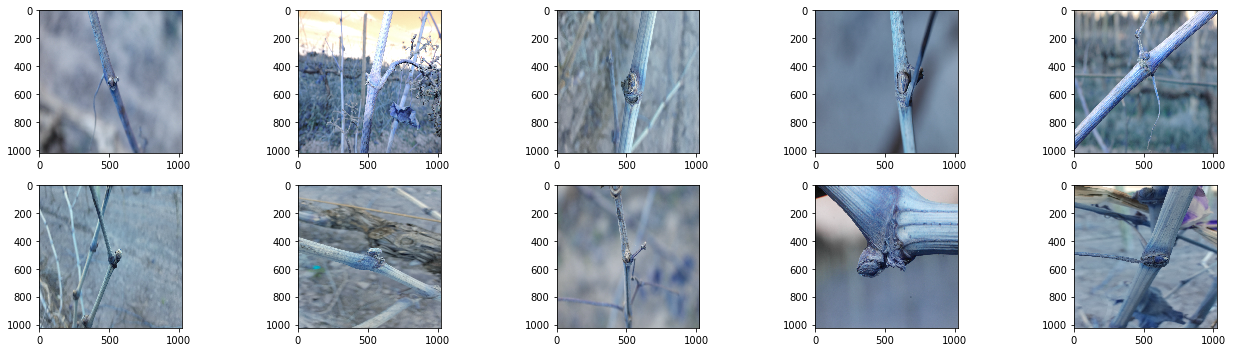

In [13]:
fig=plt.figure(figsize=(20, 5))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img = inp_img[i-1,:,:,:]
    fig.add_subplot(rows, columns, i)
    imshow(img)
plt.show()

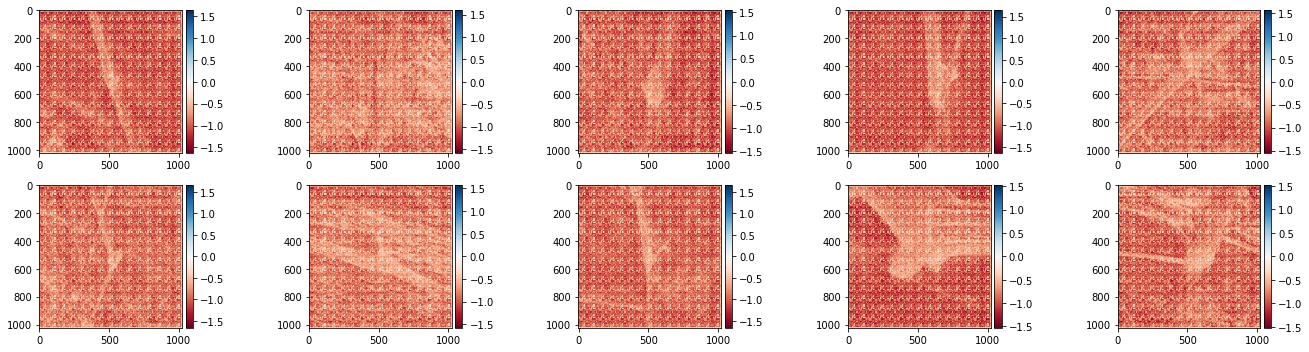

In [14]:
fig=plt.figure(figsize=(20, 5))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img = pred[i-1,:,:,0]
    fig.add_subplot(rows, columns, i)
#     plt.gray()
    imshow(img)
plt.show()

/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


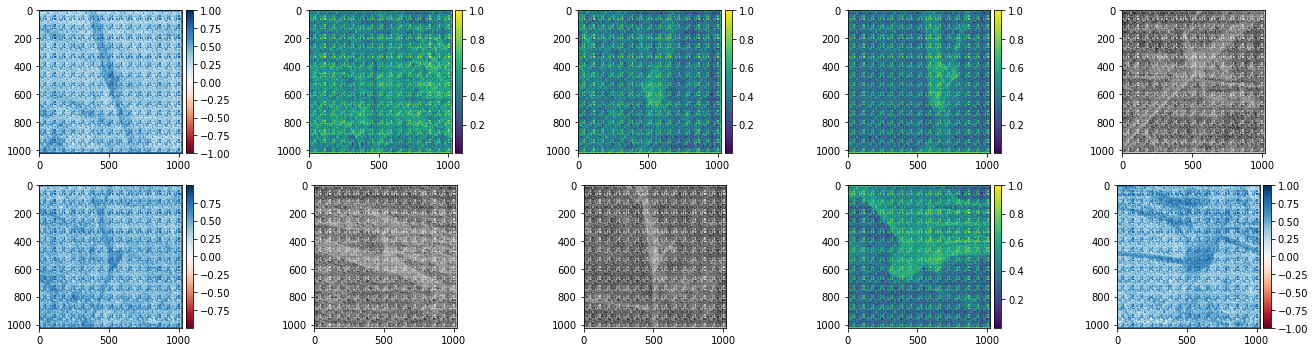

In [15]:
fig=plt.figure(figsize=(20, 5))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img = pred[i-1,:,:,0]
    img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX)
    fig.add_subplot(rows, columns, i)
#     plt.gray()
    imshow(img)
plt.show()

In [16]:
# fig=plt.figure(figsize=(20, 5))
# columns = 5
# rows = 2
# for i in range(1, columns*rows +1):
#     img = pred[i-1,:,:,0]
#     img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX)
#     img = img > 0.5
#     fig.add_subplot(rows, columns, i)
# #     plt.gray()
#     imshow(img)
# plt.show()

In [17]:
# fig=plt.figure(figsize=(20, 5))
# columns = 5
# rows = 2
# for i in range(1, columns*rows +1):
#     img = pred[i-1,:,:,0]
#     img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX)
#     img = img > 0.7
#     fig.add_subplot(rows, columns, i)
# #     plt.gray()
#     imshow(img)
# plt.show()

In [18]:
# fig=plt.figure(figsize=(20, 5))
# columns = 5
# rows = 2
# for i in range(1, columns*rows +1):
#     img = ground_truth[i-1,:,:]
#     fig.add_subplot(rows, columns, i)
#     plt.gray()
#     imshow(img)
# plt.show()

In [19]:
# normalized=cv2.normalize(pred[0,:,:,0], None, 0, 1, cv2.NORM_MINMAX)

In [20]:
# thresholded = normalized > 0.6

In [21]:
valid_generator = DataGeneratorMobileNet(batch_size=1,img_path=img_path,
                                labels=labels,list_IDs=test_images,n_channels=3,
                                n_channels_label=1,shuffle=False,mask_path=masks_path)
prediction = fcn.predict_generator(generator=valid_generator,use_multiprocessing=True,workers=6, verbose=True)

149/149 [==============================] - 24s 163ms/step


In [22]:
threshold_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [23]:
test_iou = {
    'threshold':[],
    'sample':[],
    'iou':[],
    'intersection':[],
    'union':[],
    'gt_area':[],
    'segmentation_area':[],
    'gt_x_center':[],
    'gt_y_center':[],
    'segmentation_x_center':[],
    'segmentation_y_center':[],
    'x_distance':[],
    'y_distance':[],
    'euclidean_distance':[],
    'x_size':[],
    'y_size':[]
}

In [24]:
def mass_center(mask):
    #calculate mass center from top-left corner
    x_by_mass = 0
    y_by_mass = 0
    total_mass = np.sum(mask)
    for x in np.arange(0,mask.shape[0]):
        x_by_mass += np.sum(x * mask[:,x])
        y_by_mass += np.sum(x * mask[x,:])

    return((x_by_mass/total_mass, y_by_mass/total_mass))

In [25]:
for threshold in threshold_list:    
    for i in np.arange(0,prediction.shape[0]):
        test_iou['threshold'].append(threshold)
        #get prediction and normalize
        pred = cv2.normalize(prediction[i,:,:,0], None, 0, 1, cv2.NORM_MINMAX)
        pred = (pred > threshold).astype(bool)
        #save sample name
        test_iou['sample'].append(test_images[i])
        #get mask and preprocess
        mask_name = labels[test_images[i]]
        mask = cv2.imread(masks_path + '/' + mask_name)
        mask = cv2.resize(mask, (0,0), fx=0.5, fy=0.5)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.astype(bool)

        #compute iou and areas
        intersection = np.sum(np.logical_and(pred, mask))
        union = np.sum(np.logical_or(pred, mask))
        prediction_area = np.sum(pred)
        mask_area = np.sum(mask)
        iou = intersection / union
        #add them to dict
        test_iou['iou'].append(iou)
        test_iou['intersection'].append(intersection)
        test_iou['union'].append(union)
        test_iou['gt_area'].append(mask_area)
        test_iou['segmentation_area'].append(prediction_area)
        gt_center = mass_center(mask)
        segmentation_center = mass_center(pred)
        distance = np.subtract(gt_center,segmentation_center)
        test_iou['gt_x_center'].append(gt_center[0])
        test_iou['gt_y_center'].append(gt_center[1])
        test_iou['segmentation_x_center'].append(segmentation_center[0])
        test_iou['segmentation_y_center'].append(segmentation_center[1])
        test_iou['x_distance'].append(distance[0])
        test_iou['y_distance'].append(distance[1])
        test_iou['euclidean_distance'].append(np.linalg.norm(distance))
        test_iou['x_size'].append(pred.shape[0])
        test_iou['y_size'].append(pred.shape[1])

In [26]:
data = pd.DataFrame(test_iou)

In [27]:
data.describe()

,threshold,iou,intersection,union,gt_area,segmentation_area,gt_x_center,gt_y_center,segmentation_x_center,segmentation_y_center,x_distance,y_distance,euclidean_distance,x_size,y_size
count,1341.000000,1341.000000,1341.000000,1.341000e+03,1341.000000,1.341000e+03,1341.000000,1341.000000,1341.000000,1341.000000,1341.000000,1341.000000,1341.000000,1341.0,1341.0
mean,0.500000,0.160520,9359.717375,3.706031e+05,11513.221477,3.684496e+05,506.840978,512.190747,511.868857,518.174554,-5.027880,-5.983807,75.634585,1024.0,1024.0
std,0.258295,0.212547,13905.787539,4.064891e+05,15581.801041,4.083149e+05,55.066538,64.943051,61.334636,67.819665,67.467616,79.747620,72.441934,0.0,0.0
min,0.100000,0.000000,0.000000,4.520000e+02,292.000000,1.900000e+01,330.720000,207.362486,272.526316,123.210526,-397.205408,-483.199917,0.138351,1024.0,1024.0
25%,0.300000,0.006812,1990.000000,1.518400e+04,2423.000000,1.056000e+04,478.810037,479.171649,486.141443,493.885528,-31.858104,-29.710443,25.323870,1024.0,1024.0
50%,0.500000,0.045515,4364.000000,1.453960e+05,5637.000000,1.447730e+05,511.504991,516.320413,511.511934,512.404382,-0.528363,1.448921,56.658402,1024.0,1024.0
75%,0.700000,0.256997,9896.000000,7.952470e+05,11556.000000,7.952470e+05,537.618129,546.162606,533.720324,543.795709,24.756452,29.804113,96.820535,1024.0,1024.0
max,0.900000,0.875023,89378.000000,1.048546e+06,89378.000000,1.048546e+06,654.479796,717.111905,890.658111,931.438710,345.400265,376.872842,520.261004,1024.0,1024.0


In [28]:
data.to_csv(os.path.join('.','metrics','FCNMNAdam_50ep','mobile_fcn8_metrics_adam_50ep.csv'))

In [115]:
th_dict = dict(zip(threshold_list, ['01', '02', '03', '04','05', '06', '07', '08', '09']))

In [118]:
mean_th_iou = []
for threshold in threshold_list:
    for i in np.arange(10):
        pred = cv2.normalize(prediction[i,:,:,0], None, 0, 1, cv2.NORM_MINMAX)
        pred = (pred > threshold).astype(int)*0.5
        
        mask_name = labels[test_images[i]]
        mask = cv2.imread(masks_path + '/' + mask_name)
        mask = cv2.resize(mask, (0,0), fx=0.5, fy=0.5)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.astype(bool)
        result = mask + pred
        imsave(arr=cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX).astype(int),
               fname='./metrics/FCNMNAdam_50ep/sample_images/'+ th_dict[threshold] + mask_name)

/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./metrics/FCNMNAdam_50ep/sample_images/01mask_0306.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./metrics/FCNMNAdam_50ep/sample_images/01mask_0425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./metrics/FCNMNAdam_50ep/sample_images/01mask_0561.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./metrics/FCNMNAdam_50ep/sample_images/01mask_0534.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./metrics/FCNMNAdam_50ep/sample_images/01mask_076

/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./metrics/FCNMNAdam_50ep/sample_images/05mask_0306.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./metrics/FCNMNAdam_50ep/sample_images/05mask_0425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./metrics/FCNMNAdam_50ep/sample_images/05mask_0561.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./metrics/FCNMNAdam_50ep/sample_images/05mask_0534.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./metrics/FCNMNAdam_50ep/sample_images/05mask_076

/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./metrics/FCNMNAdam_50ep/sample_images/09mask_0425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./metrics/FCNMNAdam_50ep/sample_images/09mask_0561.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./metrics/FCNMNAdam_50ep/sample_images/09mask_0534.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./metrics/FCNMNAdam_50ep/sample_images/09mask_0761.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./metrics/FCNMNAdam_50ep/sample_images/09mask_038

/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


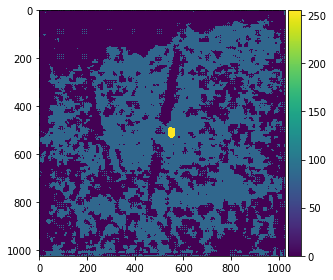

In [110]:
pred = cv2.normalize(prediction[0,:,:,0], None, 0, 1, cv2.NORM_MINMAX)
pred = (pred > 0.5).astype(int)*0.5

mask_name = labels[test_images[0]]
mask = cv2.imread(masks_path + '/' + mask_name)
mask = cv2.resize(mask, (0,0), fx=0.5, fy=0.5)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = mask.astype(bool)
result = mask + pred
imshow(cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX).astype(int))

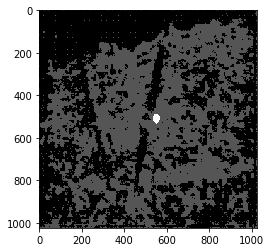

In [112]:
plt.gray()
plt.imshow(cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX).astype(int))


In [114]:
imsave(arr=cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX).astype(int), fname='./metrics/FCNMNAdam_50ep/sample_images/'+ mask_name + str(th))

/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: asd.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


In [2]:
metricas = pd.read_csv(os.path.join('.','metrics','FCNMNAdam_50ep','mobile_fcn8_metrics_adam_50ep.csv'))

In [4]:
metricas.loc[]

,Unnamed: 0,threshold,iou,intersection,union,gt_area,segmentation_area,gt_x_center,gt_y_center,segmentation_x_center,segmentation_y_center,x_distance,y_distance,euclidean_distance,x_size,y_size
count,1341.000000,1341.000000,1341.000000,1341.000000,1.341000e+03,1341.000000,1.341000e+03,1341.000000,1341.000000,1341.000000,1341.000000,1341.000000,1341.000000,1341.000000,1341.0,1341.0
mean,670.000000,0.500000,0.160520,9359.717375,3.706031e+05,11513.221477,3.684496e+05,506.840978,512.190747,511.868857,518.174554,-5.027880,-5.983807,75.634585,1024.0,1024.0
std,387.257666,0.258295,0.212547,13905.787539,4.064891e+05,15581.801041,4.083149e+05,55.066538,64.943051,61.334636,67.819665,67.467616,79.747620,72.441934,0.0,0.0
min,0.000000,0.100000,0.000000,0.000000,4.520000e+02,292.000000,1.900000e+01,330.720000,207.362486,272.526316,123.210526,-397.205408,-483.199917,0.138351,1024.0,1024.0
25%,335.000000,0.300000,0.006812,1990.000000,1.518400e+04,2423.000000,1.056000e+04,478.810037,479.171649,486.141443,493.885528,-31.858104,-29.710443,25.323870,1024.0,1024.0
50%,670.000000,0.500000,0.045515,4364.000000,1.453960e+05,5637.000000,1.447730e+05,511.504991,516.320413,511.511934,512.404382,-0.528363,1.448921,56.658402,1024.0,1024.0
75%,1005.000000,0.700000,0.256997,9896.000000,7.952470e+05,11556.000000,7.952470e+05,537.618129,546.162606,533.720324,543.795709,24.756452,29.804113,96.820535,1024.0,1024.0
max,1340.000000,0.900000,0.875023,89378.000000,1.048546e+06,89378.000000,1.048546e+06,654.479796,717.111905,890.658111,931.438710,345.400265,376.872842,520.261004,1024.0,1024.0


Recall = Intersection/GT  
Precision = Intersection/Prediction